# SEAMOUNT

This notebook shows how you can do some analysis of the SEAMOUNT experiment. 
This is an example of plot of u_max over the simulation.

# Run python script to have figure

To have figure you need 3 outputs:
- mesh_mask file (output via namelist parameter nn_msh=1 in "namdom" block)
- SEAMOUNT_xxx_1d_grid_U.nc
- run.stat.nc

## Do figure with python script: 

In [1]:
%pylab inline
from netCDF4 import Dataset
import numpy as np
import sys 
import matplotlib.pyplot as plt 
import pylab
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
exp_base = 'EXP_'
exp_names = ['xxx', 'xxx', 'xxx']
file_names = []
for exp_name in exp_names:
    file_names.append(f'../{exp_base}{exp_name}/SEAMOUNT_{exp_name}_1d_grid_U.nc')
slice_index = 38
var_name = 'utrd_hpg'
thickness_name = 'e3u'
time_1 = 0

In [3]:
# read mesh_mask
ncmesh = Dataset(f'../{exp_base}{exp_names[0]}/mesh_mask.nc')
lat2d  = ncmesh.variables['gphit'][  :,:].squeeze()
lon2d  = ncmesh.variables['glamt'][  :,:].squeeze()
msk    = ncmesh.variables['tmask'][0,:,:].squeeze()
ncmesh.close()

In [4]:
# read netcdf file

datasets = []
for file_name in file_names:
    ncfile = Dataset(file_name, mode='r')
    nav=ncfile.variables['nav_lon'][slice_index,:] 
    var=ncfile.variables[var_name][time_1,:,slice_index,:]
    thickness=ncfile.variables[thickness_name][time_1,:,slice_index,:]
    depth=thickness.squeeze()  
    depth=np.cumsum(depth,0)  
    nav=np.tile(nav,(np.size(depth,0),1))
    datasets.append([nav, depth, var])
    ncfile.close()

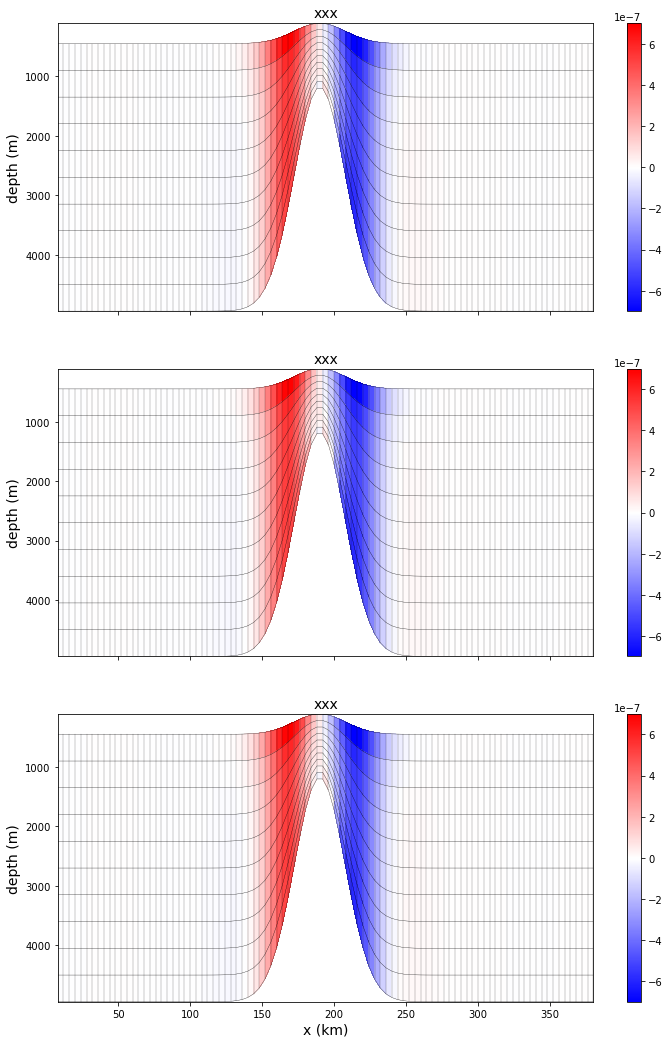

In [5]:
# plot x-z contour plot of u hpg trend

var_max = 0
var_min = 0
for dataset in datasets:
    var_max = max( var_max, max(abs(np.max(dataset[2])),abs(np.min(dataset[2]))) )
    var_min = - var_max
i=0; j=0; k=0
trimmed_datasets = []
for k in range(len(datasets)):
    trimmed_datasets.append([])
    for j in range(len(datasets[k])):
        trimmed_datasets[k].append([])
        for i in range(len(datasets[k][j])):
            trimmed_datasets[k][j].append([])
            trimmed_datasets[k][j][i] = datasets[k][j][i][1:-1]
trimmed_datasets = np.array(trimmed_datasets)
datasets = trimmed_datasets
    
fig, axarr = plt.subplots(len(file_names), 1, sharex=True, sharey=True, figsize=(12,6 * len(file_names)) )
#plt.title('HPG Trend (m/s^2)')
for i in range(len(datasets)):
    plt.sca(axarr[i])                    # set the current axes instance - this will fail for less than three experiments
    plt.pcolor(datasets[i][0],datasets[i][1],datasets[i][2],vmin=var_min,vmax=var_max,cmap='bwr')
    plt.ylabel('depth (m)',fontsize=14)  # set x label
    plt.title(exp_names[i], fontsize='14')
    for j in range(len(datasets[i][1])):
        plt.plot(datasets[i][0][j], datasets[i][1][j], color='black', linewidth = 0.3)
    plt.plot(datasets[i][0][:], datasets[i][1][:], color='black', linewidth=0.2)
    plt.colorbar()
axarr[i].invert_yaxis()
plt.xlabel('x (km)',fontsize=14)  # set x label
plt.show()


/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


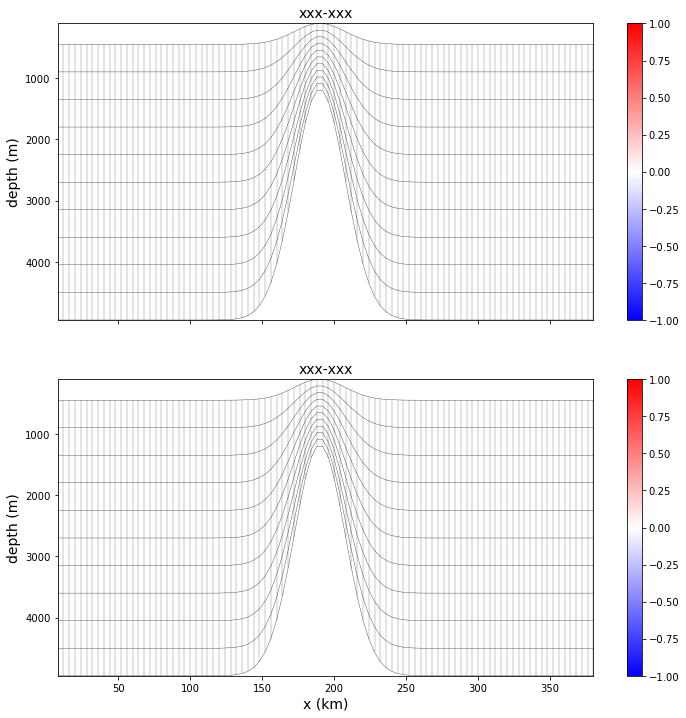

In [6]:
# plot difference to reference (reference is taken to be the experiment in the list)

var_max = 1
var_min = -1

fig, axarr = plt.subplots(len(datasets)-1, 1, sharex=True, sharey=True, figsize=(12,6*(len(datasets)-1)) )
for i in range(1,len(datasets)):
    plt.sca(axarr[i-1])                        # set the current axes instance 
    for j in range(len(datasets[i][0])):
        plt.pcolor(trimmed_datasets[i][0],trimmed_datasets[i][1], ( abs(trimmed_datasets[i][2])-abs(trimmed_datasets[0][2]) )/ abs(trimmed_datasets[0][2]),vmin=var_min,vmax=var_max, cmap='bwr')
    plt.ylabel('depth (m)',fontsize=14)  # set x label
    plt.title(exp_names[i]+'-'+exp_names[0], fontsize='14')
    for j in range(len(datasets[i][1])):
        plt.plot(trimmed_datasets[i][0][j], trimmed_datasets[i][1][j], color='black', linewidth = 0.3)
    plt.plot(trimmed_datasets[i][0][:], trimmed_datasets[i][1][:], color='black', linewidth=0.2)
    plt.colorbar()
plt.xlabel('x (km)',fontsize=14)  # set x label
axarr[i-1].invert_yaxis()
plt.show()

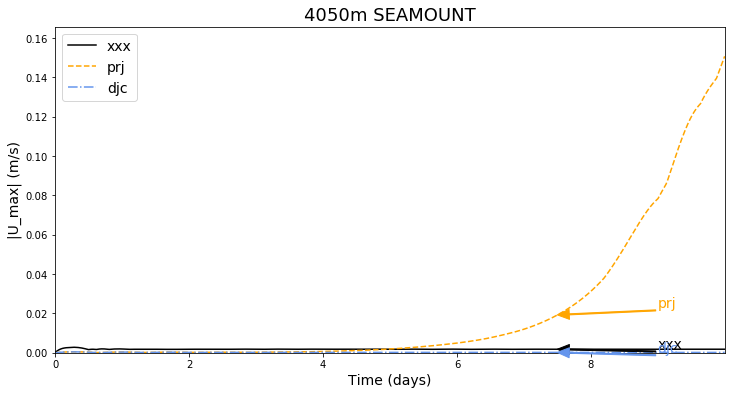

In [45]:
# plot the time series of maximum spurious velocities from run.stat.nc file

file_names = []
for exp_name in exp_names:
    file_names.append(f'../{exp_base}{exp_name}/run.stat.nc')
var_name = 'abs_u_max'
var_list = []
time_list = []
for file_name in file_names:
    ncfile = Dataset(file_name, mode='r')
    data = ncfile.variables[var_name][:]
    var_list.append( data.squeeze() )
    time = np.array(range( len(data.squeeze() ) )) * (432 / 60 / 60 / 24)
    ncfile.close()
    
colour_list = ['black', 'orange', 'cornflowerblue','yellow']
linestyles = ['-', '--', '-.', ':']
xmin = 0; xmax = time[-1]
ymin = 0; ymax = np.amax(var_list)
plt.figure(figsize=(12,6)) 
i = 0
for var in var_list:
    exp_names[i]
    colour_list[i]
    plt.plot(time, var, label=exp_names[i], color=colour_list[i], linestyle=linestyles[i])
    plt.axis([xmin, xmax, ymin, 1.1 * ymax])
    plt.annotate(exp_names[i],xy = (0.75 * xmax,var[1500]),xytext = (0.9*xmax,1.2 * var[1500]), arrowprops=dict(color=colour_list[i], width=1.1, headwidth=10), color=colour_list[i], fontsize=14)
    i = i+1
plt.ylabel('|U_max| (m/s)',fontsize=14)
plt.xlabel('Time (days)',fontsize=14)
plt.title('4050m SEAMOUNT', fontsize='18')
plt.legend(fontsize = '14')